# prepare data

In [ ]:
!git clone https://github.com/liaorongfan/DeepPersonality.git

Cloning into 'DeepPersonality'...
remote: Enumerating objects: 5721, done.
remote: Counting objects: 100% (737/737), done.
remote: Compressing objects: 100% (398/398), done.
remote: Total 5721 (delta 528), reused 500 (delta 335), pack-reused 4984 (from 1)
Receiving objects: 100% (5721/5721), 7.89 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (4217/4217), done.


In [ ]:
import os
os.chdir("/content/DeepPersonality")
os.getcwd()

'/content/DeepPersonality'

In [ ]:
!pip install -r requirements.txt

Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.9.0/index.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.1 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1)
ERROR: No matching distribution found for torch==1.9.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!gdown --id 1eANtFzA75Mqv01nW45exfauAIMLNO70J --output ChaLearn2016_tiny_processed.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1eANtFzA75Mqv01nW45exfauAIMLNO70J
From (redirected): https://drive.google.com/uc?id=1eANtFzA75Mqv01nW45exfauAIMLNO70J&confirm=t&uuid=9ef1be08-482d-4e3d-b53e-256c490d4c7a
To: /content/DeepPersonality/ChaLearn2016_tiny_processed.zip
100% 1.59G/1.59G [00:26<00:00, 59.0MB/s]


In [ ]:
!unzip ChaLearn2016_tiny_processed.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_279.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_280.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_281.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_282.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_283.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_284.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_285.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_286.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_287.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_288.jpg  
  inflating: datasets/ChaLearn2016_tiny/train_data/9hqH1PJ6cG8.001/frame_289.jpg  
  inflating: datasets/ChaLearn2016_t

# library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score

In [ ]:
!pip install torchaudio
import torchaudio

# vggish for extract features

In [ ]:
!pip install torchvggish

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.3 MB/s eta 0:00:00
  Created wheel for torchvggish: filename=torchvggish-0.2-py3-none-any.whl size=10534 sha256=60f45a5957b63ac3d2694e7b485a3d4db111588822bef5da65c0a734114bfbf1
  Stored in directory: /root/.cache/pip/wheels/b8/92/3f/652f4935ffcb94cccc2754b4bec8a88c561e360cec6da24c22
Successfully built torchvggish


# padd

In [ ]:
def pad_features(features, desired_length=64):
    current_length = features.shape[2]  # Current length
    if current_length < desired_length:
        # Pad with zeros
        padding = torch.zeros((15, 1, 96, desired_length - current_length))
        features = torch.cat((features, padding), dim=2)  # Concatenate along the last dimension
    elif current_length > desired_length:
        # Truncate
        features = features[:, :, :, :desired_length]
    return features

# Audio data class

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import pickle
from torchvggish import vggish, vggish_input


class AudioFeaturesDataset(Dataset):
    def __init__(self, audio_path, annotation_path):
        self.audio_files = []
        self.labels = []

        self.mp4_to_index = {}
        for i, audio_file in enumerate(self.audio_files):
               file_name = os.path.basename(audio_file).replace('.wav', '.mp4')
               self.mp4_to_index[file_name] = i


        # Load audio files
        for file in os.listdir(audio_path):
            if file.endswith('.wav'):
                self.audio_files.append(os.path.join(audio_path, file))

        # Load annotations
        with open(annotation_path, 'rb') as f:
            annotations = pickle.load(f, encoding='latin1')

        # Extract labels for each file
        for audio_file in self.audio_files:
            file_name = os.path.basename(audio_file).replace('.wav', '.mp4')
            label = []

            # Extract labels for all Big-Five personality traits
            for trait in annotations.keys():
                if trait != "interview":
                    trait_dict = annotations[trait]
                    if file_name in trait_dict:
                        label.append(trait_dict[file_name])
                    else:
                        label.append(-1.0)  # Default value if label is not found

            self.labels.append(torch.tensor(label, dtype=torch.float32))

    def __len__(self):
        return len(self.audio_files)


    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]

        # Extract features using VGGish
        features = vggish_input.wavfile_to_examples(audio_path)
        features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion
        # output shape of features: [15, 1, 96, 64]


        # Reshape to desired format: [1, 96, 15 * 64] --> [audio_channel=1, audio_width=96, audio_height=960]
        # num_frames, channel, width, height = features.shape
        # features = features.view(1, width, num_frames * height)  # Shape: [1, 96, 960]

        # Pad or truncate features to desired length
        features = pad_features(features)

        label = self.labels[idx]
        return features, label


    def get_data_by_mp4_name(self, mp4_name):
           if mp4_name in self.mp4_to_index:
               index = self.mp4_to_index[mp4_name]
               return self.__getitem__(index)  # Return features and label
           else:
               return None


## path data

In [ ]:
train_audio_path = '/content/DeepPersonality/datasets/ChaLearn2016_tiny/voice_data/voice_raw/train_data'
valid_audio_path = '/content/DeepPersonality/datasets/ChaLearn2016_tiny/voice_data/voice_raw/valid_data'
test_audio_path = '/content/DeepPersonality/datasets/ChaLearn2016_tiny/voice_data/voice_raw/test_data'
labels_path_train = '/content/DeepPersonality/datasets/ChaLearn2016_tiny/annotation/annotation_training.pkl'
labels_path_valid = '/content/DeepPersonality/datasets/ChaLearn2016_tiny/annotation/annotation_validation.pkl'
labels_path_test = '/content/DeepPersonality/datasets/ChaLearn2016_tiny/annotation/annotation_test.pkl'

## data set

In [ ]:
# Create datasets
train_dataset = AudioFeaturesDataset(train_audio_path, labels_path_train)
valid_dataset = AudioFeaturesDataset(valid_audio_path, labels_path_valid)
test_dataset = AudioFeaturesDataset(test_audio_path, labels_path_test)

## check the length

In [ ]:
import numpy as np

lengths = []

for idx in range(len(train_dataset)):
    features, label = train_dataset[idx]
    feature_length = features.shape[-1]
    lengths.append(feature_length)

mean_length = np.mean(lengths)
min_length = np.min(lengths)
max_length = np.max(lengths)

print(f"Average length: {mean_length}")
print(f"Minimum length: {min_length}")
print(f"Maximum length: {max_length}")

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


Average length: 64.0
Minimum length: 64
Maximum length: 64


## check shape and eaquality

In [ ]:
train_dataset[0][0].shape, train_dataset[20][0].shape

<ipython-input-19-ddeab408b034>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


(torch.Size([15, 1, 96, 64]), torch.Size([15, 1, 96, 64]))

In [ ]:
tensor1 = train_dataset[0][0]
tensor2 = train_dataset[20][0]

are_equal = torch.equal(tensor1, tensor2)

print(f"Are the tensors completely equal? {are_equal}")

<ipython-input-19-ddeab408b034>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


Are the tensors completely equal? False


# plot density of labels

In [ ]:
def plotLabelsDensity(filePath):
    gt = pickle.load(open(filePath, "rb" ), encoding='latin1')

    neuroticism = list(gt['neuroticism'].values())
    extraversion = list(gt['extraversion'].values())
    agreeableness = list(gt['agreeableness'].values())
    conscientiousness = list(gt['conscientiousness'].values())
    openness = list(gt['openness'].values())

    df = pd.DataFrame({'neuroticism': neuroticism,'extraversion': extraversion,'agreeableness':agreeableness,'conscientiousness':conscientiousness,'openness':openness})
    df.plot(kind='density',xlim=(0,1))

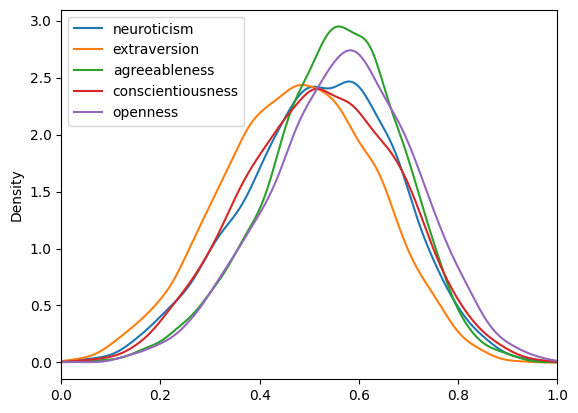

In [ ]:
plotLabelsDensity(labels_path_train)

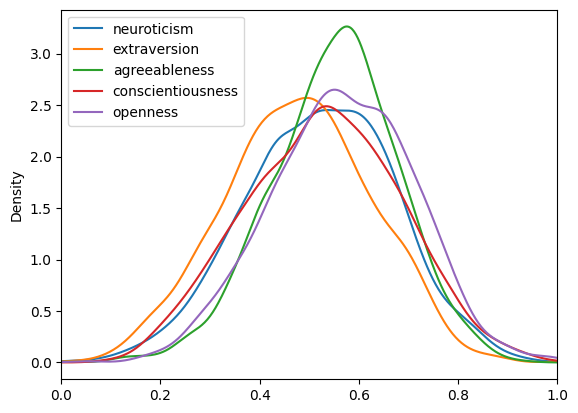

In [ ]:
plotLabelsDensity(labels_path_valid)

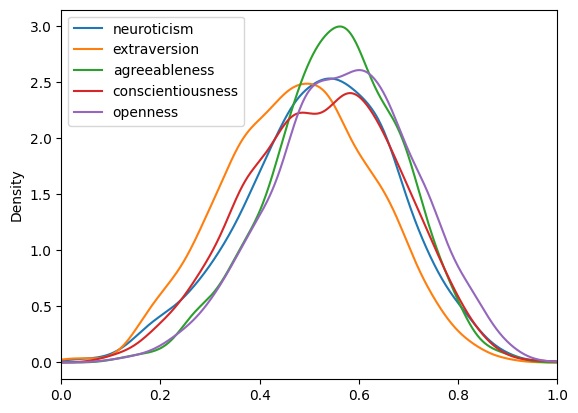

In [ ]:
plotLabelsDensity(labels_path_test)

# create data loader

In [ ]:
def pad_audio(audio, target_length):
    """Pads audio tensor with zeros to reach target length."""
    current_length = audio.shape[0]
    if current_length < target_length:
        pad_shape = (target_length - current_length,) + audio.shape[1:]
        padding = torch.zeros(pad_shape, dtype=audio.dtype, device=audio.device)
        audio = torch.cat([audio, padding], dim=0)
    return audio

In [ ]:
def custom_collate_fn(batch):
    """Custom collate function to pad audio tensors."""
    # Determine maximum audio length
    max_length = max([item[0].shape[0] for item in batch])

    # Pad audios and stack
    audios = [pad_audio(item[0], max_length) for item in batch]
    audios = torch.stack(audios)

    # Stack labels
    labels = torch.stack([item[1] for item in batch])

    return audios, labels

In [ ]:
training_batch_size = 4
training_shuffle = False

validation_batch_size = 4
validation_shuffle = False

test_batch_size = 10
test_shuffle = False

train_dataloader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=training_shuffle, collate_fn=custom_collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=validation_batch_size, shuffle=validation_shuffle, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=test_shuffle, collate_fn=custom_collate_fn)

## check representation

In [ ]:
# Get a batch of data from the dataloader
data = iter(train_dataloader)

# Access the shape of the first element in the first batch
next(data), next(data)

<ipython-input-19-ddeab408b034>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


([tensor([[[[[-1.6185, -1.5847, -1.1902,  ..., -3.4072, -3.5870, -3.4306],
             [-2.1195, -1.6062, -1.1916,  ..., -3.4606, -3.3710, -3.4906],
             [-1.9159, -1.7382, -1.6869,  ..., -2.8378, -2.5718, -3.2384],
             ...,
             [-1.1377, -2.0529, -0.1281,  ..., -3.0333, -2.6990, -2.2411],
             [-0.8143, -1.2311, -0.0753,  ..., -3.2123, -3.2395, -2.2268],
             [-0.2991, -1.2939,  0.1386,  ..., -3.1798, -3.2643, -2.3432]]],
  
  
           [[[-0.0626, -0.0465,  0.5948,  ..., -2.8954, -3.1693, -2.4981],
             [-0.1258,  0.0101,  0.7601,  ..., -2.8014, -2.8344, -2.4375],
             [ 0.0076,  0.2959,  0.8440,  ..., -2.6690, -2.7176, -2.6978],
             ...,
             [-0.4506,  0.1578,  0.3346,  ..., -3.2503, -3.5987, -4.0602],
             [-0.5263,  0.1499,  0.1762,  ..., -2.4552, -2.9378, -2.9855],
             [-0.4448, -0.0204, -0.2610,  ..., -3.2503, -3.2236, -3.3454]]],
  
  
           [[[-0.6437, -1.5323, -1.1919,  ..., -

In [ ]:
# Iterate through the DataLoader to access the data
for batch_idx, data in enumerate(test_dataloader):
    if batch_idx == 0:  # Access the first batch
        # Get the shape of the desired element in the batch
        shape = data[0].shape  # Assuming you want the shape of the first element in the batch
        print(shape)
        break  # Stop after processing the first batch


<ipython-input-12-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


torch.Size([10, 15, 1, 96, 64])


# define Vgg model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch import flatten

class Vgg(nn.Module):
    def __init__(self, numChannels=1, classes=5):
      super(Vgg, self).__init__()

      self.conv1 = Conv2d(in_channels=numChannels, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.relu1 = ReLU()
      self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


      self.conv2 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.relu2 = ReLU()
      self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


      self.conv3 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.relu3 = ReLU()
      self.conv4 = Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.relu4 = ReLU()
      self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


      self.conv5 = Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
      self.relu5 = ReLU()
      self.conv6 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
      self.relu6 = ReLU()
      self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


      # self.conv7 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
      # self.relu7 = ReLU()
      # self.conv8 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
      # self.relu8 = ReLU()
      # self.maxpool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


      # initialize first (and only) set of FC => RELU layers
      self.fc1 = Linear(in_features=512 * 6 * 4, out_features=4096)
      self.relu9 = ReLU()

      self.fc2 = Linear(in_features=4096, out_features=4096)
      self.relu10 = ReLU()

      self.fc3 = Linear(in_features=4096, out_features=128)
      self.relu11 = ReLU()

      self.fc4 = Linear(in_features=128, out_features=classes)
      self.sigmoid = Sigmoid()


    def forward(self, x):
      print("input: ", x.shape)

      x = self.conv1(x)
      print("after conv1: ", x.shape)
      x = self.relu1(x)
      x = self.maxpool1(x)
      print("after maxpool1: ", x.shape)


      x = self.conv2(x)
      print("after conv2: ", x.shape)
      x = self.relu2(x)
      x = self.maxpool2(x)
      print("after maxpool2: ", x.shape)

      x = self.conv3(x)
      print("after conv3: ", x.shape)
      x = self.relu3(x)
      x = self.conv4(x)
      print("after conv4: ", x.shape)
      x = self.relu4(x)
      x = self.maxpool3(x)
      print("after maxpool3: ", x.shape)

      x = self.conv5(x)
      print("after conv5: ", x.shape)
      x = self.relu5(x)
      x = self.conv6(x)
      print("after conv6: ", x.shape)
      x = self.relu6(x)
      x = self.maxpool4(x)
      print("after maxpool4: ", x.shape)


      # x = self.conv7(x)
      # x = self.relu7(x)
      # x = self.conv8(x)
      # x = self.relu8(x)
      # x = self.maxpool5(x)
      # print("after conv7 , conv8: ", x.shape)

      x = x.view(x.size(0), -1)
      print("after flatten: ", x.shape)

      x = self.fc1(x)
      print("after fc1: ", x.shape)
      x = self.relu9(x)

      x = self.fc2(x)
      print("after fc2: ", x.shape)

      x = self.fc3(x)
      print("after fc3: ", x.shape)
      x = self.relu11(x)

      x = self.fc4(x)
      print("after fc3: ", x.shape)
      output = self.sigmoid(x)

      return output

In [ ]:
num_classes = 5  # 5 personality traits

model = Vgg(
    classes=num_classes,
)

learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# set hyper parameters

In [ ]:
start_epoch = 0
n_epochs = 10

In [ ]:
history = {
           "meanLossTraining":[], "meanAccuracyTraining":[], "meanLossValidation":[],
           "meanAccuracyValidation":[], "meanLossTest":[], "meanAccuracyTest":[],
           "meanR2Training": [], "meanR2Validation": [], "meanR2Test": [],
           "meanCCCTraining": [], "meanCCCValidation": [], "meanCCCTest": [],
           "meanPCCTraining": [], "meanPCCValidation": [], "meanPCCTest": [],

           "O_AccuracyTraining":-1, "C_AccuracyTraining":-1, "E_AccuracyTraining":-1, "A_AccuracyTraining":-1, "N_AccuracyTraining":-1,
           "O_AccuracyValidation":-1, "C_AccuracyValidation":-1, "E_AccuracyValidation":-1, "A_AccuracyValidation":-1, "N_AccuracyValidation":-1,
           "O_AccuracyTest":-1, "C_AccuracyTest":-1, "E_AccuracyTest":-1, "A_AccuracyTest":-1, "N_AccuracyTest":-1,

           "O_R2Training":-1, "C_R2Training":-1, "E_R2Training":-1, "A_R2Training":-1, "N_R2Training":-1,
           "O_R2Validation":-1, "C_R2Validation":-1, "E_R2Validation":-1, "A_R2Validation":-1, "N_R2Validation":-1,
           "O_R2Test":-1, "C_R2Test":-1, "E_R2Test":-1, "A_R2Test":-1, "N_R2Test":-1,

           "O_CCCTraining":-1, "C_CCCTraining":-1, "E_CCCTraining":-1, "A_CCCTraining":-1, "N_CCCTraining":-1,
           "O_CCCValidation":-1, "C_CCCValidation":-1, "E_CCCValidation":-1, "A_CCCValidation":-1, "N_CCCValidation":-1,
           "O_CCCTest":-1, "C_CCCTest":-1, "E_CCCTest":-1, "A_CCCTest":-1, "N_CCCTest":-1,

           "O_PCCTraining":-1, "C_PCCTraining":-1, "E_PCCTraining":-1, "A_PCCTraining":-1, "N_PCCTraining":-1,
           "O_PCCValidation":-1, "C_PCCValidation":-1, "E_PCCValidation":-1, "A_PCCValidation":-1, "N_PCCValidation":-1,
           "O_PCCTest":-1, "C_PCCTest":-1, "E_PCCTest":-1, "A_PCCTest":-1, "N_PCCTest":-1
           }

### count parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### set model and dataset Info

In [ ]:
data = next(iter(train_dataloader))
audioFrameNum, audioChannelNum, audioHeight, audioWidth = data[0][0].shape
audioSegmentNum = 1

modality = "Audio"
preTrainedModel = "No"
datasetName = "Tiny chalearn"
weights = None

modelName = model.__class__.__name__

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


In [ ]:
modelInfo = {
    "modality": modality,
    "model": model.__class__.__name__,
    "parametersNum": count_parameters(model),
    "weights": weights,
    "dataset": datasetName,
    "feature": {
        "audio": {
            "audioSegmentNum": audioSegmentNum,
            "audioWidth": audioWidth,
            "audioHeight": audioHeight,
            "audioChannelNum": audioChannelNum
        },
    },
    "hyperparameters": {
        "EpochNum": n_epochs,
        "batchSizeTraining": training_batch_size,
        "batchSizeValidation": validation_batch_size,
        "batchSizeTest": test_batch_size,
        "trainingShuffle": False,
        "validationShuffle": False,
        "testShuffle": False,
        "optimizer": optimizer.__class__.__name__,
        "learningRate": optimizer.param_groups[0]['lr'],
        "lossFunctionTraining": criterion2.__class__.__name__,
        "lossFunctionEvaluation": {
            "Training": criterion1.__class__.__name__,
            "Validation": criterion1.__class__.__name__,
            "Test": criterion1.__class__.__name__
        }

    }
}

torchInfo = {
    "torchVersion": torch.__version__,
    "torchDevice": {
        "type": device,
        "cudaVersion": torch.version.cuda if torch.cuda.is_available() else None,
        "GPUName": torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else None
    }

}

# define metric method

## pcc

In [ ]:
def pearson_correlation_coefficient(y_true, y_pred):
  return np.corrcoef(y_true, y_pred)[0][1]

## ccc

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""

    # Raw data
    dct = {
        'y_true': y_true,
        'y_pred': y_pred
    }
    df = pd.DataFrame(dct)

    # Remove NaNs
    df = df.dropna()

    # Pearson product-moment correlation coefficients
    y_true = df['y_true']
    y_pred = df['y_pred']
    cor = np.corrcoef(y_true, y_pred)[0][1]

    # Means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)

    # Population variances
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)

    # Population standard deviations
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)

    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2

    return numerator / denominator

# Create row in csv file

In [ ]:
def createRow(modelInfo, history, epoch, elapsedTime, torchInfo):

    new_row = {"modality": modelInfo["modality"],
               "model":  modelInfo["model"],
               "parametersNum": modelInfo["parametersNum"],

               "meanAccuracyTraining": history["meanAccuracyTraining"][epoch],
               "meanAccuracyValidation": history["meanAccuracyValidation"][epoch],
               "meanAccuracyTest": history["meanAccuracyTest"][epoch],

               "meanR2Training": history["meanR2Training"][epoch],
               "meanR2Validation": history["meanR2Validation"][epoch],
               "meanR2Test": history["meanR2Test"][epoch],

               "meanCCCTraining": history["meanCCCTraining"][epoch],
               "meanCCCValidation": history["meanCCCValidation"][epoch],
               "meanCCCTest": history["meanCCCTest"][epoch],

               "meanLossTraining": history["meanLossTraining"][epoch],
               "meanLossValidation": history["meanLossValidation"][epoch],
               "meanLossTest": history["meanLossTest"][epoch],
               "elapsedTime": elapsedTime,
               "weights": modelInfo["weights"],
               "dataset": modelInfo["dataset"],

               "audioSegmentNum": modelInfo["feature"]["audio"]["audioSegmentNum"],
               "audioWidth": modelInfo["feature"]["audio"]["audioWidth"],
               "audioHeight": modelInfo["feature"]["audio"]["audioHeight"],
               "audioChannelNum": modelInfo["feature"]["audio"]["audioChannelNum"],

               "EpochNum": modelInfo["hyperparameters"]["EpochNum"],
               "batchSizeTraining": modelInfo["hyperparameters"]["batchSizeTraining"],
               "trainingShuffle": modelInfo["hyperparameters"]["trainingShuffle"],
               "batchSizeValidation": modelInfo["hyperparameters"]["batchSizeValidation"],
               "validationShuffle": modelInfo["hyperparameters"]["validationShuffle"],
               "batchSizeTest": modelInfo["hyperparameters"]["batchSizeTest"],
               "testShuffle": modelInfo["hyperparameters"]["testShuffle"],
               "optimizer": modelInfo["hyperparameters"]["optimizer"],
               "learningRate": modelInfo["hyperparameters"]["learningRate"],
               "lossFunctionEvaluationTraining": modelInfo["hyperparameters"]["lossFunctionEvaluation"]["Training"],
               "lossFunctionEvaluationValidation": modelInfo["hyperparameters"]["lossFunctionEvaluation"]["Validation"],
               "lossFunctionEvaluationTest": modelInfo["hyperparameters"]["lossFunctionEvaluation"]["Test"],
               "lossFunctionTraining": modelInfo["hyperparameters"]["lossFunctionTraining"],

               "torchVersion": torchInfo["torchVersion"],
               "torchDevice": torchInfo["torchDevice"]["type"],
               "torchCudaVersion": torchInfo["torchDevice"]["cudaVersion"],
               "GPUName": torchInfo["torchDevice"]["GPUName"],

                "O_AccuracyTraining": history["O_AccuracyTraining"],
                "C_AccuracyTraining": history["C_AccuracyTraining"],
                "E_AccuracyTraining": history["E_AccuracyTraining"],
                "A_AccuracyTraining": history["A_AccuracyTraining"],
                "N_AccuracyTraining": history["N_AccuracyTraining"],

                "O_AccuracyValidation": history["O_AccuracyValidation"],
                "C_AccuracyValidation": history["C_AccuracyValidation"],
                "E_AccuracyValidation": history["E_AccuracyValidation"],
                "A_AccuracyValidation": history["A_AccuracyValidation"],
                "N_AccuracyValidation": history["N_AccuracyValidation"],

                "O_AccuracyTest": history["O_AccuracyTest"],
                "C_AccuracyTest": history["C_AccuracyTest"],
                "E_AccuracyTest": history["E_AccuracyTest"],
                "A_AccuracyTest": history["A_AccuracyTest"],
                "N_AccuracyTest": history["N_AccuracyTest"],

                "O_R2Training": history["O_R2Training"],
                "C_R2Training": history["C_R2Training"],
                "E_R2Training": history["E_R2Training"],
                "A_R2Training": history["A_R2Training"],
                "N_R2Training": history["N_R2Training"],

                "O_R2Validation": history["O_R2Validation"],
                "C_R2Validation": history["C_R2Validation"],
                "E_R2Validation": history["E_R2Validation"],
                "A_R2Validation": history["A_R2Validation"],
                "N_R2Validation": history["N_R2Validation"],

                "O_R2Test": history["O_R2Test"],
                "C_R2Test": history["C_R2Test"],
                "E_R2Test": history["E_R2Test"],
                "A_R2Test": history["A_R2Test"],
                "N_R2Test": history["N_R2Test"],


                "O_CCCTraining": history["O_CCCTraining"],
                "C_CCCTraining": history["C_CCCTraining"],
                "E_CCCTraining": history["E_CCCTraining"],
                "A_CCCTraining": history["A_CCCTraining"],
                "N_CCCTraining": history["N_CCCTraining"],

                "O_CCCValidation": history["O_CCCValidation"],
                "C_CCCValidation": history["C_CCCValidation"],
                "E_CCCValidation": history["E_CCCValidation"],
                "A_CCCValidation": history["A_CCCValidation"],
                "N_CCCValidation": history["N_CCCValidation"],

                "O_CCCTest": history["O_CCCTest"],
                "C_CCCTest": history["C_CCCTest"],
                "E_CCCTest": history["E_CCCTest"],
                "A_CCCTest": history["A_CCCTest"],
                "N_CCCTest": history["N_CCCTest"]

               }
    return new_row

# Evaluate metrics

In [ ]:
def check_data(y_true, y_pred):
    print(f"y_true: {y_true}")
    print(f"y_pred: {y_pred}")
    print(f"Stddev y_true: {np.std(y_true)}")
    print(f"Stddev y_pred: {np.std(y_pred)}")

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score

def evaluationMetrics(y_true, y_pred, wantedMetrics, phase):
    yt = np.array([np.array(item) for sublist in y_true for item in sublist])
    yp = np.array([np.array(item) for sublist in y_pred for item in sublist])

    accuracy = []
    r2Score = []
    concordanceCC = []
    label_name = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']

    for metric in wantedMetrics[phase].keys():
        for i in range(len(label_name)):
            # yt[:, i], yp[:, i] = preprocess_data(yt[:, i], yp[:, i])

            if metric == "mae":
                print("for mae:")
                check_data(yt[:,i], yp[:,i])
                wantedMetrics[phase][metric].append(mean_absolute_error(yt[:,i], yp[:,i]))

            elif metric == "r2":
                print("for r2:")
                check_data(yt[:,i], yp[:,i])
                wantedMetrics[phase][metric].append(r2_score(yt[:,i], yp[:,i]))

            elif metric == "accuracy":
                print("for accuracy:")
                check_data(yt[:,i], yp[:,i])
                wantedMetrics[phase][metric].append(1 - mean_absolute_error(yt[:,i], yp[:,i]))

            elif metric == "ccc":
                print("for ccc:")
                check_data(yt[:,i], yp[:,i])
                wantedMetrics[phase][metric].append(concordance_correlation_coefficient(yt[:,i], yp[:,i]))

            elif metric == "pcc":
                print("for pcc:")
                check_data(yt[:,i], yp[:,i])
                wantedMetrics[phase][metric].append(pearson_correlation_coefficient(yt[:,i], yp[:,i]))

    return wantedMetrics

# train func

In [ ]:
import torch
import torchaudio

def trainAudioModel(model, criterion, optimizer, train_loader, device):
    model.train()
    training_losses = []

    for batch in train_loader:
        audios, labels = batch
        audios = audios.to(device)
        labels = labels.to(device)

        # Pad the audio sequences in the batch
        audios = torch.nn.utils.rnn.pad_sequence(audios, batch_first=True)


        Total = training_batch_size * audioFrameNum
        audios = audios.reshape(Total, audioChannelNum, audioWidth, audioHeight)


        # # Cast audios to float
        # audios = audios.float()

        # # Cast labels to float
        # labels = labels.float()


        optimizer.zero_grad()
        outputs = model(audios)


        outputs = outputs.reshape(Total//audioFrameNum, audioFrameNum, -1)
        outputs = outputs.mean(dim=1)


        print("Predicted Labels:", outputs.detach().cpu().numpy())
        print("True Labels:", labels.detach().cpu().numpy())

        # print(f"Shape of outputs: {outputs.shape}")
        # print(f"Shape of labels: {labels.shape}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

    return training_losses

# Evaluate func

In [ ]:
def evaluateAudioModel(model, criterion, valid_loader, device):
    model.eval()
    y_pred = []
    y_true = []
    losses = []

    with torch.no_grad():
        for batch in valid_loader:
            audios, labels = batch
            audios = audios.to(device)
            labels = labels.to(device)

            audios = torch.nn.utils.rnn.pad_sequence(audios, batch_first=True)


            Total = valid_loader.batch_size * audioFrameNum
            audios = audios.reshape(Total, audioChannelNum, audioWidth, audioHeight)


            # # Cast audios to float
            # audios = audios.float()

            # # Cast labels to float
            # labels = labels.float()


            outputs = model(audios)


            outputs = outputs.reshape(Total//audioFrameNum, audioFrameNum, -1)
            outputs = outputs.mean(dim=1)


            print("Predicted Labels:", outputs.detach().cpu().numpy())
            print("True Labels:", labels.detach().cpu().numpy())


            loss = criterion(outputs, labels)
            losses.append(loss.item())

            y_pred.append(outputs.cpu().numpy())
            y_true.append(labels.cpu().numpy())

    return losses, y_pred, y_true

# update history

In [ ]:
def updateHistory(history, phase, accuracy, r2Score, concordanceCC, pearsonCC, losses):
    acc = np.array(accuracy).mean()
    r2 = np.array(r2Score).mean()
    ccc = np.array(concordanceCC).mean()
    pcc = np.array(pearsonCC).mean()

    labesName = ["E_", "N_", "A_", "C_", "O_"]

    for i in range(len(labesName)):
        history[labesName[i]+"Accuracy"+phase] = accuracy[i]
        history[labesName[i]+"R2"+phase] = r2Score[i]
        history[labesName[i]+"CCC"+phase] = concordanceCC[i]
        history[labesName[i]+"PCC"+phase] = pearsonCC[i]

    history["meanLoss"+phase].append(np.nan_to_num(np.mean(losses)))
    history["meanAccuracy"+phase].append(np.nan_to_num(np.mean(acc)))
    history["meanR2"+phase].append(np.nan_to_num(np.mean(r2)))
    history["meanCCC"+phase].append(np.nan_to_num(np.mean(ccc)))
    history["meanPCC"+phase].append(np.nan_to_num(np.mean(pcc)))

    return history

# run

In [ ]:
import datetime
import pandas as pd
import os

modelsCsvPath = "/content/vgg.csv"
best_accuracy = -1
best_epoch = -1

phases = ["Training", "Validation", "Test"]
phases_dataloader = [train_dataloader, valid_dataloader, test_dataloader]


metrics = ["accuracy", "r2", "ccc", "pcc"]
wantedMetrics = {}
for phase in phases:
  wantedMetrics[phase] = {}
  for metric in metrics:
    wantedMetrics[phase][metric] = []


t1 = datetime.datetime.utcnow()
for epoch in range(start_epoch, n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    # Training
    print("training...")
    training_losses = trainAudioModel(model, criterion2, optimizer, train_dataloader, device)

    # Evaluation
    for i in range(len(phases)):
        print(f"evaluating {phases[i]}...")
        losses, y_pred, y_true = evaluateAudioModel(model, criterion1, phases_dataloader[i], device)

        if phases[i] == "Test":
            test_predictions = y_pred
            test_labels = y_true

        if phases[i] == "Validation":
            validation_predictions = y_pred
            validation_labels = y_true

        wantedMetrics = evaluationMetrics(y_true, y_pred, wantedMetrics, phases[i])

        if phases[i] == "Training":
            losses = training_losses

        history = updateHistory(history, phases[i],
                                    wantedMetrics[phases[i]]["accuracy"],
                                    wantedMetrics[phases[i]]["r2"],
                                    wantedMetrics[phases[i]]["ccc"],
                                    wantedMetrics[phases[i]]["pcc"], losses)

    # Check for best accuracy and save model
    if history["meanAccuracyValidation"][epoch] > best_accuracy:
        best_accuracy = history["meanAccuracyValidation"][epoch]
        best_epoch = epoch

        if not os.path.isfile(modelsCsvPath):
                haveHeader = True

        new_row = createRow(modelInfo = modelInfo, history = history,
                            epoch = epoch, elapsedTime = None,
                            torchInfo = torchInfo)

t2 = datetime.datetime.utcnow()

new_row["elapsedTime"] = str(t2-t1)

Epoch 1/10
training...


<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48092368 0.5050882  0.5170719  0.48479745 0.48398757]
 [0.48087496 0.5051448  0.51706535 0.48482314 0.48403552]
 [0.4809452  0.5051036  0.5170331  0.48481464 0.48402622]
 [0.48093164 0.50512147 0.51703596 0.4848293  0.48402503]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48116368 0.50535125 0.5173119  0.48514014 0.484562  ]
 [0.4811433  0.50532323 0.51733667 0.48516464 0.48451295]
 [0.48111904 0.5053033  0.51732534 0.48515043 0.48451498]
 [0.48113164 0.5053882  0.51731396 0.48515627 0.4845512 ]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.48121685 0.5053614  0.51727116 0.48514992 0.48457205]
 [0.4812209  0.5053616  0.5172393  0.48511297 0.4845991 ]
 [0.4812279  0.5053748  0.51724076 0.4851195  0.48460978]
 [0.4811805  0.50534433 0.5172622  0.48514438 0.48455685]
 [0.48123816 0.5053723  0.5172288  0.48509157 0.48461923]
 [0.4811526  0.5053

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48118582 0.5053369  0.51729614 0.48512045 0.48454893]
 [0.4811356  0.505393   0.5172901  0.48514473 0.48459494]
 [0.48120844 0.5053544  0.51725864 0.48514014 0.48459157]
 [0.48119485 0.50537145 0.51726127 0.48515454 0.48458993]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48141947 0.50559634 0.5175367  0.48545876 0.48511666]
 [0.481396   0.5055652  0.51756054 0.48547962 0.48506206]
 [0.4813736  0.50554633 0.5175482  0.48546627 0.48506534]
 [0.48138586 0.50563073 0.5175383  0.48547196 0.48510212]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.4814758  0.50560904 0.5174962  0.48547214 0.4851323 ]
 [0.4814806  0.5056108  0.5174645  0.48543736 0.4851632 ]
 [0.48148736 0.50562406 0.5174663  0.48544398 0.48517415]
 [0.4814384  0.5055918  0.517486   0.48546553 0.4851147 ]
 [0.4815001  0.5056222  0.51745456 0.48541802 0.4851864 ]
 [0.48140925 0.5055

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48144406 0.50558406 0.5175203  0.48544174 0.4851073 ]
 [0.48139188 0.5056393  0.5175148  0.48546407 0.48515093]
 [0.48146814 0.5056044  0.51748395 0.48546454 0.48515466]
 [0.48145416 0.50561976 0.5174867  0.48547783 0.48515177]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48166853 0.50583583 0.5177628  0.48577204 0.48566455]
 [0.4816409  0.50579995 0.5177868  0.48578823 0.48560315]
 [0.4816177  0.5057808  0.5177744  0.48577422 0.4856059 ]
 [0.48163205 0.5058673  0.5177644  0.48578164 0.4856455 ]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.48172593 0.505851   0.51772344 0.48578802 0.4856847 ]
 [0.48173296 0.5058549  0.5176909  0.48575592 0.4857201 ]
 [0.48173627 0.5058668  0.5176939  0.48576033 0.48572877]
 [0.48168844 0.505833   0.51771164 0.48578036 0.48566464]
 [0.48175398 0.5058668  0.51768166 0.4857383  0.48574615]
 [0.48165777 0.5058

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.4816952  0.50582594 0.51774603 0.48575804 0.4856593 ]
 [0.4816395  0.5058788  0.5177416  0.4857765  0.48569864]
 [0.4817212  0.5058486  0.51771086 0.48578346 0.48571086]
 [0.4817065  0.5058628  0.5177136  0.485796   0.48570716]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48190895 0.50606954 0.5179904  0.48607823 0.48620373]
 [0.48187828 0.5060304  0.5180136  0.48609075 0.48613685]
 [0.4818534  0.5060105  0.51800144 0.4860755  0.48613828]
 [0.4818683  0.506098   0.51799196 0.4860837  0.4861794 ]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.4819655  0.5060861  0.51795274 0.48609546 0.48622686]
 [0.4819758  0.5060925  0.51791906 0.48606685 0.4862677 ]
 [0.4819743  0.5061027  0.5179235  0.48606804 0.486273  ]
 [0.48192787 0.50606686 0.51793975 0.48608682 0.4862043 ]
 [0.48199585 0.50610507 0.51791114 0.48604968 0.4862952 ]
 [0.48189676 0.5060

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.4819359  0.50606084 0.5179738  0.48606616 0.48620132]
 [0.4818794  0.5061135  0.51796937 0.4860827  0.48623848]
 [0.48196504 0.50608665 0.51793957 0.486095   0.48625803]
 [0.4819488  0.50610006 0.51794255 0.4861064  0.48625308]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.4821427  0.50629985 0.518218   0.48637912 0.48673612]
 [0.48210952 0.5062579  0.5182401  0.48638842 0.48666424]
 [0.48208463 0.50623816 0.5182279  0.48637313 0.48666573]
 [0.4820988  0.5063262  0.5182194  0.4863813  0.4867074 ]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.4821988  0.50631785 0.5181823  0.48639783 0.4867626 ]
 [0.48221102 0.50632566 0.5181481  0.4863717  0.48680753]
 [0.48220772 0.5063351  0.5181532  0.48637187 0.48681194]
 [0.48215958 0.50629705 0.5181685  0.48638728 0.48673645]
 [0.48223117 0.5063395  0.51814157 0.4863558  0.4868374 ]
 [0.48212805 0.5062

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48216975 0.506292   0.51820207 0.48636883 0.4867363 ]
 [0.4821125  0.50634426 0.5181977  0.4863834  0.48677123]
 [0.48219946 0.50632054 0.5181699  0.48639938 0.48679653]
 [0.48218337 0.5063328  0.51817226 0.48641056 0.48679125]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48237112 0.50652826 0.5184458  0.48667577 0.487263  ]
 [0.48233652 0.50648373 0.51846623 0.48668253 0.4871869 ]
 [0.48231202 0.5064643  0.5184537  0.4866676  0.4871887 ]
 [0.48232552 0.5065531  0.5184465  0.48667574 0.48723108]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.4824283  0.50654763 0.5184115  0.4866969  0.48729372]
 [0.48244217 0.50655645 0.5183772  0.48667306 0.48734266]
 [0.4824382  0.5065656  0.5183828  0.48667306 0.487347  ]
 [0.48238784 0.5065256  0.51839685 0.48668483 0.48726445]
 [0.48246285 0.50657165 0.51837206 0.4866587  0.48737502]
 [0.48235512 0.5065

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48239905 0.5065212  0.5184302  0.48666778 0.4872663 ]
 [0.48234078 0.5065734  0.5184264  0.48668024 0.48729873]
 [0.48242766 0.5065524  0.518401   0.48669901 0.48732892]
 [0.4824125  0.5065634  0.5184025  0.48671046 0.48732373]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48259565 0.5067555  0.51867354 0.48696914 0.4877853 ]
 [0.4825604  0.5067086  0.5186918  0.4869739  0.48770547]
 [0.48253673 0.5066895  0.5186787  0.48695943 0.48770756]
 [0.48254922 0.50677925 0.51867324 0.4869676  0.48775095]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.48265374 0.50677663 0.51864094 0.48699254 0.4878199 ]
 [0.48266897 0.506786   0.5186064  0.48697096 0.48787305]
 [0.48266527 0.5067949  0.51861215 0.48697138 0.48787794]
 [0.48261285 0.5067531  0.5186248  0.48697963 0.48778847]
 [0.48269063 0.5068025  0.518603   0.48695827 0.48790807]
 [0.48257884 0.5067

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.4826254  0.5067495  0.5186576  0.4869638  0.4877918 ]
 [0.4825657  0.5068014  0.51865476 0.4869743  0.48782218]
 [0.4826529  0.50678277 0.5186317  0.48699594 0.4878573 ]
 [0.4826386  0.50679284 0.51863235 0.48700768 0.48785233]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48281807 0.5069818  0.51890016 0.48726013 0.48830357]
 [0.48278278 0.5069331  0.5189155  0.4872627  0.48821887]
 [0.48275945 0.5069141  0.5189024  0.48724884 0.4882222 ]
 [0.4827709  0.50700486 0.5188986  0.48725688 0.48826638]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.48287705 0.5070047  0.51886934 0.48728576 0.48834231]
 [0.48289317 0.5070144  0.51883507 0.48726636 0.48839957]
 [0.48288915 0.5070236  0.5188412  0.48726678 0.48840463]
 [0.48283502 0.5069796  0.5188522  0.48727188 0.4883085 ]
 [0.4829146  0.5070326  0.5188345  0.4872544  0.48843628]
 [0.48280063 0.5069

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48284915 0.5069769  0.5188841  0.48725724 0.4883134 ]
 [0.48278862 0.5070286  0.5188818  0.48726556 0.4883409 ]
 [0.48287672 0.50701225 0.518861   0.48729074 0.48838186]
 [0.48286223 0.5070213  0.5188616  0.48730236 0.48837715]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48303968 0.5072076  0.5191247  0.48754904 0.48881736]
 [0.48300457 0.5071572  0.5191366  0.48754933 0.48872763]
 [0.48298168 0.50713825 0.5191238  0.4875362  0.48873225]
 [0.48299208 0.5072299  0.51912147 0.4875442  0.4887772 ]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.48309898 0.507232   0.51909655 0.48757708 0.488861  ]
 [0.48311576 0.50724185 0.5190625  0.48755962 0.48892215]
 [0.4831104  0.5072515  0.51906997 0.48755932 0.48892665]
 [0.4830559  0.5072053  0.51907825 0.487562   0.48882467]
 [0.4831356  0.507262   0.5190657  0.48754746 0.48895952]
 [0.4830221  0.5071

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48307186 0.50720376 0.5191089  0.48754838 0.48883015]
 [0.48301107 0.5072552  0.5191065  0.48755494 0.48885524]
 [0.48309794 0.5072408  0.51909    0.48758274 0.48890188]
 [0.48308447 0.507249   0.5190892  0.4875948  0.48889774]]
True Labels: [[0.5420561  0.5625     0.46153846 0.5631068  0.46666667]
 [0.7943925  0.864583

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([60, 1, 64, 96])
after conv1:  torch.Size([60, 64, 64, 96])
after maxpool1:  torch.Size([60, 64, 32, 48])
after conv2:  torch.Size([60, 128, 32, 48])
after maxpool2:  torch.Size([60, 128, 16, 24])
after conv3:  torch.Size([60, 256, 16, 24])
after conv4:  torch.Size([60, 256, 16, 24])
after maxpool3:  torch.Size([60, 256, 8, 12])
after conv5:  torch.Size([60, 512, 8, 12])
after conv6:  torch.Size([60, 512, 8, 12])
after maxpool4:  torch.Size([60, 512, 4, 6])
after flatten:  torch.Size([60, 12288])
after fc1:  torch.Size([60, 4096])
after fc2:  torch.Size([60, 4096])
after fc3:  torch.Size([60, 128])
after fc3:  torch.Size([60, 5])
Predicted Labels: [[0.48325998 0.50743276 0.5193479  0.48783585 0.48932704]
 [0.4832255  0.5073808  0.51935565 0.48783392 0.48923203]
 [0.48320362 0.50736207 0.5193424  0.48782176 0.48923755]
 [0.48321265 0.5074543  0.5193424  0.48782972 0.48928404]]
True Labels: [[0.6635514  0.5208333  0.3956044  0.6407767  0.67777777]
 [0.48598132 0.583333

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])
Predicted Labels: [[0.48331916 0.5074587  0.5193225  0.4878661  0.48937494]
 [0.4833364  0.50746864 0.51928926 0.4878505  0.48944062]
 [0.48332846 0.5074793  0.51929915 0.48784876 0.48944366]
 [0.48327565 0.50743055 0.51930255 0.48785    0.48933616]
 [0.48335356 0.5074909  0.519297   0.48783743 0.48947787]
 [0.4832427  0.5074

# Plot regression to the mean

## test

In [ ]:
test_predictions_mean = np.mean(test_predictions, axis=0)
test_labels_mean = np.mean(test_labels, axis=0)

test_prediction_differences = test_predictions - test_predictions_mean
test_label_differences = test_labels - test_labels_mean

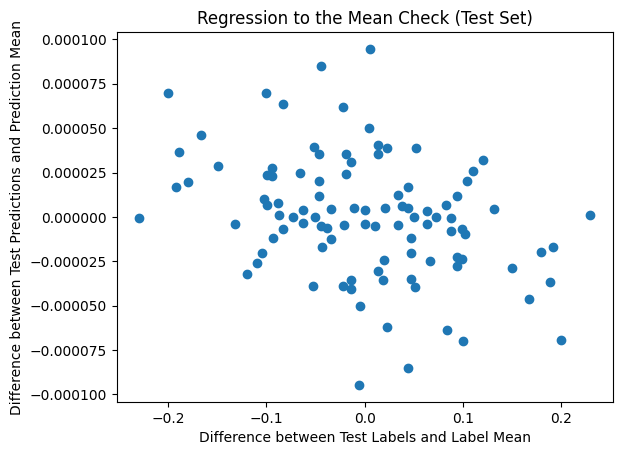

In [ ]:
plt.scatter(test_label_differences, test_prediction_differences)
plt.xlabel("Difference between Test Labels and Label Mean")
plt.ylabel("Difference between Test Predictions and Prediction Mean")
plt.title("Regression to the Mean Check (Test Set)")
plt.show()

## validation

In [ ]:
validation_predictions_mean = np.mean(validation_predictions, axis=0)
validation_labels_mean = np.mean(validation_labels, axis=0)

validation_prediction_differences = validation_predictions - validation_predictions_mean
validation_label_differences = validation_labels - validation_labels_mean

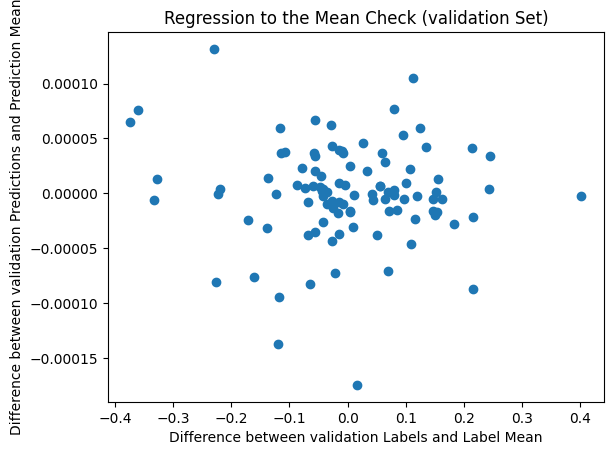

In [ ]:
plt.scatter(validation_label_differences, validation_prediction_differences)
plt.xlabel("Difference between validation Labels and Label Mean")
plt.ylabel("Difference between validation Predictions and Prediction Mean")
plt.title("Regression to the Mean Check (validation Set)")
plt.show()

# Shap

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.0 MB/s eta 0:00:00


In [ ]:
import shap

explainer = shap.Explainer(model, train_dataloader)

In [ ]:
# از دیتالودر تست یک نمونه بگیرید
data_iter = iter(test_dataloader)

# فقط داده‌های صوتی را استخراج کنید (بدون لیبل)
audios, _ = next(data_iter)  # audios شامل ویژگی‌ها (داده‌های صوتی) است، لیبل‌ها استفاده نمی‌شوند

# reshape داده‌ها به شکل مناسب برای مدل
Total = audios.size(0) * audioFrameNum  # بچ‌سایز * تعداد فریم‌ها
audios_reshaped = audios.reshape(Total, audioChannelNum, audioWidth, audioHeight)

if torch.cuda.is_available():
    model.cuda()
    audios_reshaped = audios_reshaped.cuda()

# ایجاد explainer با مدل و داده‌های reshape شده
explainer = shap.DeepExplainer(model, audios_reshaped)

<ipython-input-10-0877262d7d23>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).clone().detach().float()  # Safe tensor conversion


input:  torch.Size([150, 1, 64, 96])
after conv1:  torch.Size([150, 64, 64, 96])
after maxpool1:  torch.Size([150, 64, 32, 48])
after conv2:  torch.Size([150, 128, 32, 48])
after maxpool2:  torch.Size([150, 128, 16, 24])
after conv3:  torch.Size([150, 256, 16, 24])
after conv4:  torch.Size([150, 256, 16, 24])
after maxpool3:  torch.Size([150, 256, 8, 12])
after conv5:  torch.Size([150, 512, 8, 12])
after conv6:  torch.Size([150, 512, 8, 12])
after maxpool4:  torch.Size([150, 512, 4, 6])
after flatten:  torch.Size([150, 12288])
after fc1:  torch.Size([150, 4096])
after fc2:  torch.Size([150, 4096])
after fc3:  torch.Size([150, 128])
after fc3:  torch.Size([150, 5])


In [ ]:
# محاسبه مقادیر SHAP برای داده‌ها
shap_values = explainer.shap_values(audios_reshaped)

Streaming output truncated to the last 5000 lines.
after conv5:  torch.Size([300, 512, 8, 12])
after conv6:  torch.Size([300, 512, 8, 12])
after maxpool4:  torch.Size([300, 512, 4, 6])
after flatten:  torch.Size([300, 12288])
after fc1:  torch.Size([300, 4096])
after fc2:  torch.Size([300, 4096])
after fc3:  torch.Size([300, 128])
after fc3:  torch.Size([300, 5])
input:  torch.Size([300, 1, 64, 96])
after conv1:  torch.Size([300, 64, 64, 96])
after maxpool1:  torch.Size([300, 64, 32, 48])
after conv2:  torch.Size([300, 128, 32, 48])
after maxpool2:  torch.Size([300, 128, 16, 24])
after conv3:  torch.Size([300, 256, 16, 24])
after conv4:  torch.Size([300, 256, 16, 24])
after maxpool3:  torch.Size([300, 256, 8, 12])
after conv5:  torch.Size([300, 512, 8, 12])
after conv6:  torch.Size([300, 512, 8, 12])
after maxpool4:  torch.Size([300, 512, 4, 6])
after flatten:  torch.Size([300, 12288])
after fc1:  torch.Size([300, 4096])
after fc2:  torch.Size([300, 4096])
after fc3:  torch.Size([300, 

In [ ]:
print(shap_values.shape)

(150, 1, 64, 96, 5)


In [ ]:
shap_values2 = np.array(shap_values)
shap_values2.shape

(150, 1, 64, 96, 5)

In [ ]:
audios_reshaped.shape

torch.Size([150, 1, 64, 96])

In [ ]:
shap_values = np.mean(shap_values, axis=1)
shap_values.shape

(150, 64, 96, 5)

In [ ]:
shap.plots.bar(shap_values)

# Save csv

In [ ]:
df = pd.DataFrame(columns = new_row.keys())
df.loc[0] = new_row
df.to_csv(modelsCsvPath, mode="a", header=haveHeader, index=False)